In [13]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: WANDB_SILENT=true


In [14]:
import h5py

file = h5py.File('data/DAS/south30_50Hz_UTC_20230226_085300.122.h5')

data = file['DAS'][:]
data = data[:512, 600:512 + 600]
data.shape

(512, 512)

In [15]:
import torch

y = torch.Tensor(data)
y /= y.std()
y = y.T
y = y.unsqueeze(0).unsqueeze(0)
y.shape

torch.Size([1, 1, 512, 512])

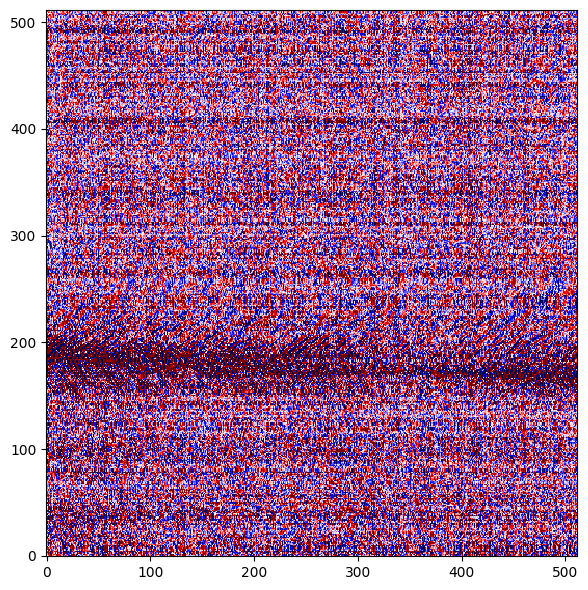

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,6))
ax.imshow(y.squeeze().numpy(), origin='lower', interpolation='nearest', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

In [17]:
from denoisers.dip import DIP, SGDIP, PatchDIP, losses, schedules
from models import UNetMod

net = UNetMod(in_ch=1, out_ch=1, hidden_ch=8, n_layers=3)
# loss = losses.Composed(losses.NMSE(), losses.TV(), alpha=0.1)
# loss = losses.NMSE()
linear = schedules.Linear(1, 10)
loss = losses.Composed(losses.MSE(), losses.AE(), linear)
# dip = SGDIP(net, loss, max_epochs=2000)
dip = PatchDIP(net, losses.MSE(), epochs=50, threshold=0.2)

options = {
    "mode": "local",
    "config": {
        "project": "",
        "entity": "",
        "group": "",
        "dataset": "",
        "denoiser_id": 0,
        "data_id": 0,
    },
    "metrics": {},
    "log_output": False,
}

x_hat = dip.denoise(y, logging_options=options)

Running: 0 - PatchDIP (epochs=50) - MSE - UNetMod 


100%|██████████| 50/50 [02:06<00:00,  2.53s/it]


Summary: {'runtime': '00:02:11'}



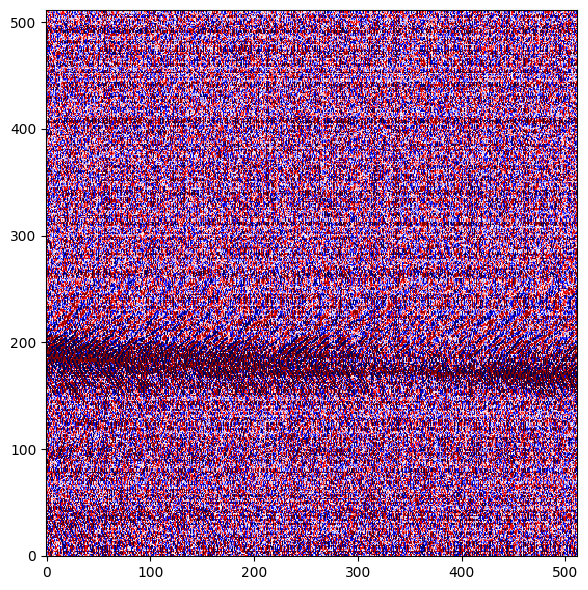

In [18]:
x_hat = x_hat.detach().cpu().squeeze()

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,6))
ax.imshow(x_hat.numpy(), origin='lower', interpolation='nearest', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

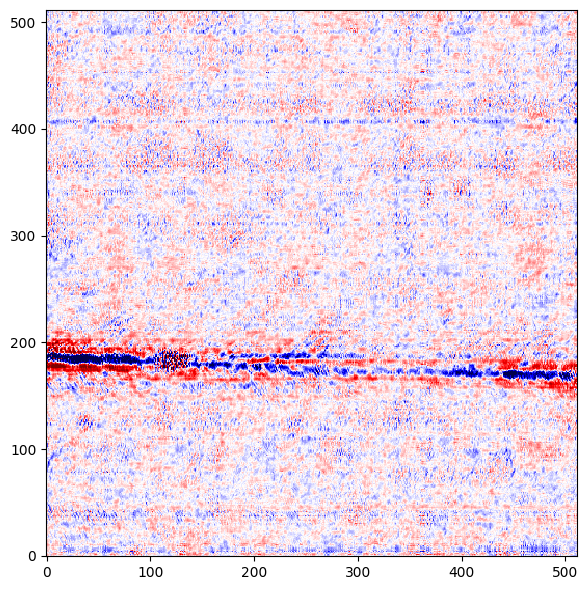

In [20]:
diff = y - x_hat

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,6))
ax.imshow(diff.squeeze().numpy(), origin='lower', interpolation='nearest', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()